In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from datetime import datetime
import time

from uplift.metrics import uplift_at_k,qini_auc_score
from uplift.ensemble import RandomForestClassifier
from uplift.vizualization import plot_uplift_preds, plot_uplift_qini_curves

In [3]:
N_ROWS = 19000000 #number of samples

df_dataset = pd.read_csv("DATASETS/criteo-uplift.csv", nrows = N_ROWS)

df_features = pd.DataFrame({
    'f0': df_dataset['f0'],
    'f1': df_dataset['f1'],
    'f2': df_dataset['f2'],
    'f3': df_dataset['f3'],
    'f4': df_dataset['f4'],
    'f5': df_dataset['f5'],
    'f6': df_dataset['f6'],
    'f7': df_dataset['f7'],
    'f8': df_dataset['f8'],
    'f9': df_dataset['f9'],
    'f10': df_dataset['f10'],
    'f11': df_dataset['f11'],
})

df_features_imp = pd.DataFrame({
    'f0': df_dataset['f0'],
    'f1': df_dataset['f1'],
    'f2': df_dataset['f2'],
    'f3': df_dataset['f3'],
    'f4': df_dataset['f4'],
    'f5': df_dataset['f5'],
    'f6': df_dataset['f6'],
    'f7': df_dataset['f7'],
    'f8': df_dataset['f8'],
    'f9': df_dataset['f9'],
    'f10': df_dataset['f10'],
    'f11': df_dataset['f11'],
    'visit':df_dataset['visit'],
    'treatment':df_dataset['treatment']
})

indices_all =  [i for i in range(N_ROWS)]

indices_train, indices_test = train_test_split(
         df_dataset.index,
         test_size=0.3,
         random_state = 12)

# feature importance

In [8]:
features = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']

dict_feat ={}
regularization = 1.0
for name_feature in features:
    df_features_imp = df_features_imp.sort_values(name_feature)
    df_features_imp = df_features_imp.reset_index(drop=True)
    # print(df_features_imp)
    num_bins = 100
    indices_train_bins = np.array_split(indices_train, num_bins)
    indices_test_bins = np.array_split(indices_test, num_bins)
    NIV = 0
    penalty = 0
    for i in range(0, num_bins):
        group_train = df_features_imp.iloc[indices_train_bins[i]]
        group_test = df_features_imp.iloc[indices_test_bins[i]]

        number_of_treat = (group_train.loc[ (group_train['treatment'] == 1) ]).shape[0]
        number_of_control = (group_train.loc[ (group_train['treatment'] == 0) ]).shape[0]

        number_of_succ_treat = (group_train.loc[(group_train['visit'] == 1) & (group_train['treatment'] == 1)]).shape[0]
        number_of_succ_control = (group_train.loc[(group_train['visit'] == 1) & (group_train['treatment'] == 0)]).shape[0]

        number_of_fail_control = (group_train.loc[(group_train['visit'] == 0) & (group_train['treatment'] == 0)]).shape[0]
        number_of_fail_treat = (group_train.loc[(group_train['visit'] == 0) & (group_train['treatment'] == 1)]).shape[0]
        #print("treat",number_of_treat,"control",number_of_control,"succ_treat", number_of_succ_treat, "succ_control", number_of_succ_control,"fail_treat", number_of_fail_treat,"fail_control",number_of_fail_control)

        succ_rate_treat = number_of_succ_treat / number_of_treat
        fail_rate_treat = number_of_fail_treat / number_of_treat

        succ_rate_control = number_of_succ_control / number_of_control 
        fail_rate_control = number_of_fail_control / number_of_control 
        
        up = (succ_rate_treat + regularization) / (fail_rate_treat + (2 * regularization))
        down = (succ_rate_control + regularization) / (fail_rate_control + (2 * regularization))
        
        NWOE_train = np.log(up / down)
        
        NIV += (succ_rate_treat * fail_rate_control - fail_rate_treat * succ_rate_control) * NWOE_train
        
        number_of_treat = (group_test.loc[ (group_test['treatment'] == 1) ]).shape[0]
        number_of_control = (group_test.loc[ (group_test['treatment'] == 0) ]).shape[0]

        number_of_succ_treat = (group_test.loc[(group_test['visit'] == 1) & (group_test['treatment'] == 1)]).shape[0]
        number_of_succ_control = (group_test.loc[(group_test['visit'] == 1) & (group_test['treatment'] == 0)]).shape[0]

        number_of_fail_control = (group_test.loc[(group_test['visit'] == 0) & (group_test['treatment'] == 0)]).shape[0]
        number_of_fail_treat = (group_test.loc[(group_test['visit'] == 0) & (group_test['treatment'] == 1)]).shape[0]
        #print("treat",number_of_treat,"control",number_of_control,"succ_treat", number_of_succ_treat, "succ_control", number_of_succ_control,"fail_treat", number_of_fail_treat,"fail_control",number_of_fail_control)

        succ_rate_treat = number_of_succ_treat / number_of_treat
        fail_rate_treat = number_of_fail_treat / number_of_treat

        succ_rate_control = number_of_succ_control / number_of_control 
        fail_rate_control = number_of_fail_control / number_of_control 
        
        up = (succ_rate_treat + regularization) / (fail_rate_treat + (2 * regularization))
        down = (succ_rate_control + regularization) / (fail_rate_control + (2 * regularization))
        
        NWOE_test = np.log(up / down)
        
        w = abs(NWOE_train-NWOE_test)
        penalty += (succ_rate_treat * fail_rate_control - fail_rate_treat * succ_rate_control) * w
        
    
    dict_feat[name_feature] = NIV - penalty
    
list_d = list(dict_feat.items())
list_d.sort(key=lambda i: i[1],reverse=True)
for i in list_d:
    print(i[0], ':', i[1])

f2 : 0.03851992272068308
f5 : 0.038313430545202504
f6 : 0.038076518898930566
f1 : 0.038068765165714696
f10 : 0.03786571252827755
f11 : 0.03783336753238654
f8 : 0.03782887666530519
f4 : 0.037585670684430396
f0 : 0.03755045527225942
f7 : 0.037504033110983236
f3 : 0.0370492094659426
f9 : 0.03681636761218826


In [3]:
X_train = df_features.loc[indices_train]
treatment_train = df_dataset.loc[indices_train,'treatment']
visit_train = df_dataset.loc[indices_train,'visit']

X_test = df_features.loc[indices_test]
Y_test_visit =  df_dataset.loc[indices_test,'visit']
treatment_test = df_dataset.loc[indices_test,'treatment']

In [37]:
from pprint import pprint

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 45, num = 5)]

# Number of features to consider at every split
max_features = [0.1, 0.7, 1.0]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
#min_samples_split = [500, 1000, 2000, 5000, 10000]
# Minimum number of samples required at each leaf node
min_samples_leaf = [500, 2000, 7000, 15000,30000,60000,120000,300000,400000,500000,600000,700000,800000,900000,1000000]
# Method of selecting samples for training each tree
#bootstrap = [True, False]


param_grid = {
              'max_features':max_features,
               'min_samples_leaf': min_samples_leaf}

pprint(param_grid)

{'max_features': [0.1, 0.7, 1.0],
 'min_samples_leaf': [500,
                      2000,
                      7000,
                      15000,
                      30000,
                      60000,
                      120000,
                      300000,
                      400000,
                      500000,
                      600000,
                      700000,
                      800000,
                      900000,
                      1000000]}


In [38]:
from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)
pprint(grid_list)


[{'max_features': 0.1, 'min_samples_leaf': 500},
 {'max_features': 0.1, 'min_samples_leaf': 2000},
 {'max_features': 0.1, 'min_samples_leaf': 7000},
 {'max_features': 0.1, 'min_samples_leaf': 15000},
 {'max_features': 0.1, 'min_samples_leaf': 30000},
 {'max_features': 0.1, 'min_samples_leaf': 60000},
 {'max_features': 0.1, 'min_samples_leaf': 120000},
 {'max_features': 0.1, 'min_samples_leaf': 300000},
 {'max_features': 0.1, 'min_samples_leaf': 400000},
 {'max_features': 0.1, 'min_samples_leaf': 500000},
 {'max_features': 0.1, 'min_samples_leaf': 600000},
 {'max_features': 0.1, 'min_samples_leaf': 700000},
 {'max_features': 0.1, 'min_samples_leaf': 800000},
 {'max_features': 0.1, 'min_samples_leaf': 900000},
 {'max_features': 0.1, 'min_samples_leaf': 1000000},
 {'max_features': 0.7, 'min_samples_leaf': 500},
 {'max_features': 0.7, 'min_samples_leaf': 2000},
 {'max_features': 0.7, 'min_samples_leaf': 7000},
 {'max_features': 0.7, 'min_samples_leaf': 15000},
 {'max_features': 0.7, 'min_s

{'max_features': 0.1, 'min_samples_leaf': 500}
fitting time  1:35:03.647597
[-0.00246169  0.00017044  0.04485289 ... -0.011022    0.00065909
 -0.00246169]
0.05186132032477931
408415363248.80035


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 2000}
fitting time  0:47:07.803629
[-0.0008592   0.00145593  0.04807974 ...  0.01587786  0.00176684
 -0.0008592 ]
0.05416397502922349
408643601280.2864


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 7000}
fitting time  0:13:22.667479
[0.00367838 0.00367838 0.04231567 ... 0.01623528 0.00390826 0.00367838]
0.05449511420824446
405256759697.74854


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 15000}
fitting time  0:12:22.107654
[0.00219719 0.00219719 0.05019645 ... 0.02344078 0.00236569 0.00219719]
0.05672193342500957
408882891039.4794


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 30000}
fitting time  0:05:04.862627
[0.0043023  0.0043023  0.04963614 ... 0.02160643 0.00444893 0.0043023 ]
0.05705639603946289
408355185693.32404


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 60000}
fitting time  0:05:41.361035
[0.00354056 0.00354056 0.04439936 ... 0.02443077 0.00365129 0.00354056]
0.056953190186745675
417929600910.64417


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 120000}
fitting time  0:01:38.895191
[0.00966855 0.00966855 0.05009976 ... 0.01732907 0.00970795 0.00966855]
0.056935997282236916
407836591171.0191


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 300000}
fitting time  0:01:01.930171
[0.01399342 0.01399342 0.0283252  ... 0.02028637 0.01399342 0.01399342]
0.05622334995551449
388947502155.22644


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 400000}
fitting time  0:00:48.982508
[0.01476218 0.01476218 0.018845   ... 0.018845   0.01476218 0.01476218]
0.056933175142111256
362534617223.05084


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 500000}
fitting time  0:00:55.818411
[0.01192423 0.01192423 0.02226968 ... 0.0191938  0.01192423 0.01192423]
0.056116913034836416
375590242784.94104


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 600000}
fitting time  0:00:47.424811
[0.01209165 0.01209165 0.02069838 ... 0.02603689 0.01209165 0.01209165]
0.0566164721917979
349828729270.6248


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 700000}
fitting time  0:00:45.689593
[0.01228747 0.01228747 0.01940442 ... 0.02594831 0.01228747 0.01228747]
0.057450970148915495
389410926806.5147


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 800000}
fitting time  0:00:49.134763
[0.01213674 0.01213674 0.02509532 ... 0.02509532 0.01213674 0.01213674]
0.05516768929743433
364042719613.004


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 900000}
fitting time  0:00:50.469986
[0.01240446 0.01240446 0.02988665 ... 0.02426463 0.01240446 0.01240446]
0.055077943089186746
386454165786.5758


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.1, 'min_samples_leaf': 1000000}
fitting time  0:00:40.078462
[0.01479612 0.01479612 0.02139373 ... 0.02570691 0.01479612 0.01479612]
0.05612489699210961
376718887566.90814


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 500}
fitting time  2:45:32.166362
[-0.00227995  0.00030979  0.04197536 ... -0.00589276  0.00074117
 -0.00227995]
0.04962617189368718
393764905365.2981


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 2000}
fitting time  1:02:15.299832
[-0.00032997  0.00091572  0.03614491 ...  0.0054371   0.00110057
 -0.00032997]
0.05179309125354315
406291767377.6121


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 7000}
fitting time  0:41:57.448578
[0.00015012 0.00038505 0.03451738 ... 0.00746159 0.00083053 0.00015012]
0.053583023987945344
410610898073.9674


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 15000}
fitting time  0:27:23.524602
[0.00058041 0.00058041 0.03302084 ... 0.00848481 0.00074903 0.00058041]
0.054488741749479624
404016546324.3484


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 30000}
fitting time  0:20:26.539758
[0.00058188 0.00058188 0.03070518 ... 0.01372407 0.00061299 0.00058188]
0.05493639487129237
397738661545.9156


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 60000}
fitting time  0:12:24.199757
[0.00055383 0.00055383 0.03474176 ... 0.02277925 0.00055383 0.00055383]
0.055246346028467494
400408134554.49084


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 120000}
fitting time  0:12:07.029381
[0.00038901 0.00038901 0.04400865 ... 0.01873948 0.00049354 0.00038901]
0.05699103663724553
407857380103.1856


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 300000}
fitting time  0:07:48.599107
[0.0005199  0.0005199  0.04285466 ... 0.02106234 0.00080175 0.0005199 ]
0.05674713988025326
416110055834.3337


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 400000}
fitting time  0:06:42.072595
[-0.00018048  0.00047714  0.02567928 ...  0.03843741  0.00076724
 -0.00018048]
0.05748199575486633
411476101629.13715


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 500000}
fitting time  0:06:20.760264
[-0.00080625  0.00046598  0.03273606 ...  0.01955341  0.00080155
 -0.00080625]
0.05703773870698299
421474457788.1974


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 600000}
fitting time  0:04:57.809216
[0.00050906 0.00070355 0.03702872 ... 0.04386946 0.00105981 0.00050906]
0.057475066400957564
408275409143.78955


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 700000}
fitting time  0:04:52.498054
[-0.0009239   0.00059391  0.03108411 ...  0.0370697   0.0009101
 -0.0009239 ]
0.0569301826153876
405031046151.4469


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 800000}
fitting time  0:04:08.156023
[0.00021324 0.00063382 0.03997372 ... 0.03997372 0.00113668 0.00021324]
0.05703125235822898
396493527790.0185


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 900000}
fitting time  0:04:33.457890
[-0.00042705  0.00080993  0.03201193 ...  0.03201193  0.00095376
 -0.00042705]
0.056732836373737786
417023880757.4179


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 0.7, 'min_samples_leaf': 1000000}
fitting time  0:04:12.742507
[-0.00140692  0.00076381  0.04815686 ...  0.03767038  0.00074448
 -0.00140692]
0.05728474277745964
404422567785.3586


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\vizualization\graphics.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


{'max_features': 1.0, 'min_samples_leaf': 500}


KeyboardInterrupt: 

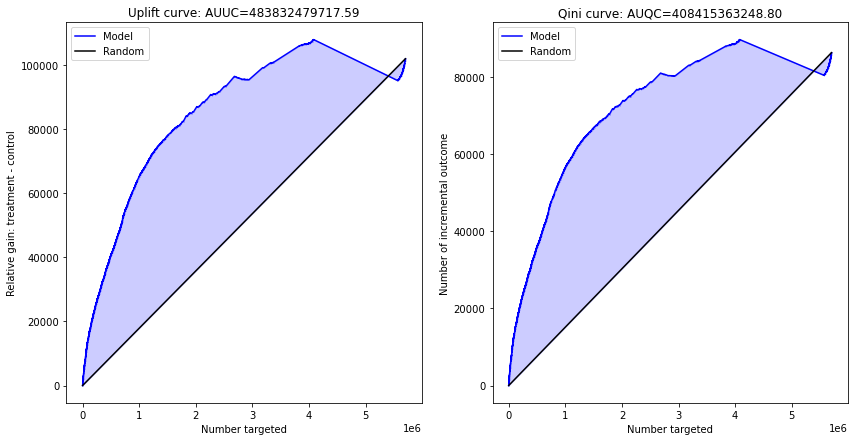

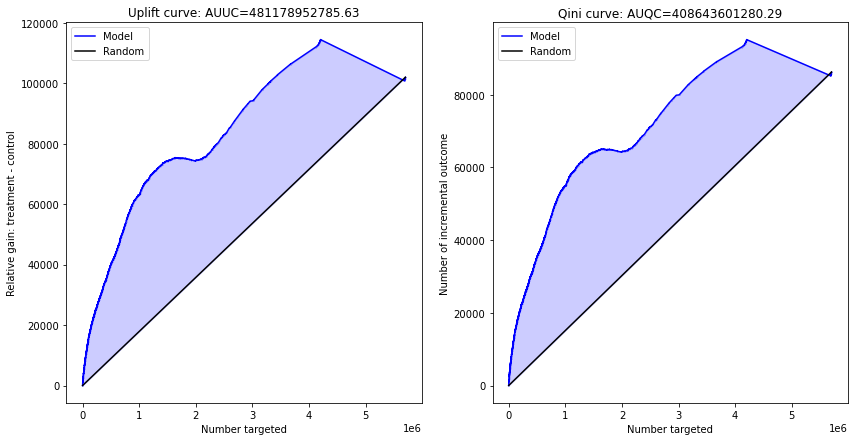

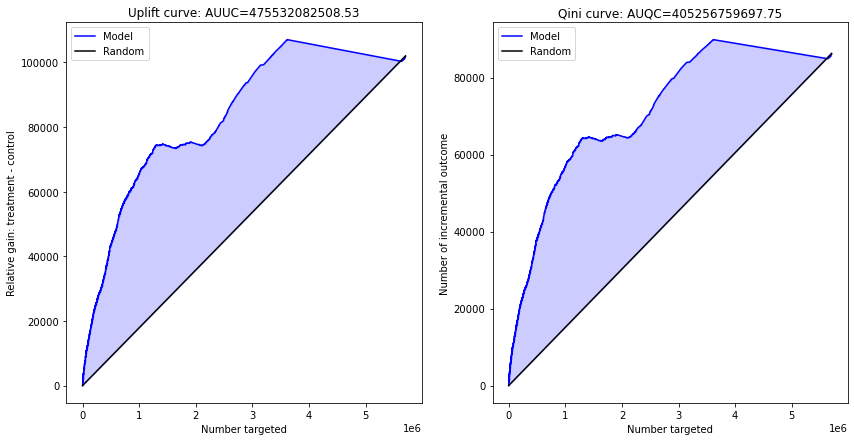

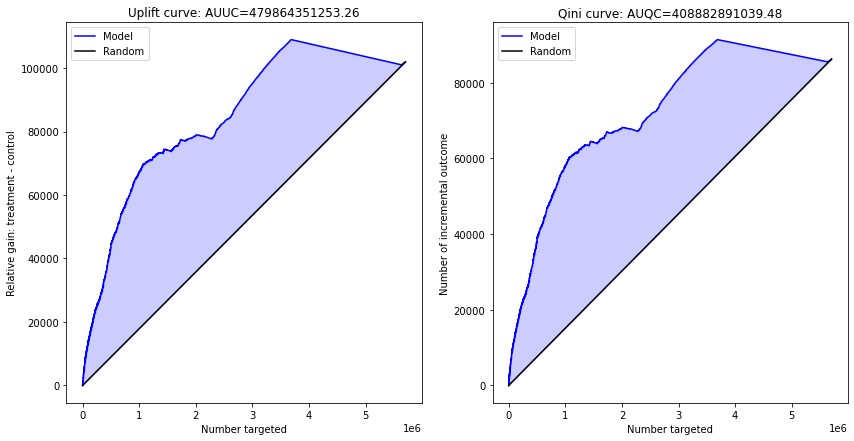

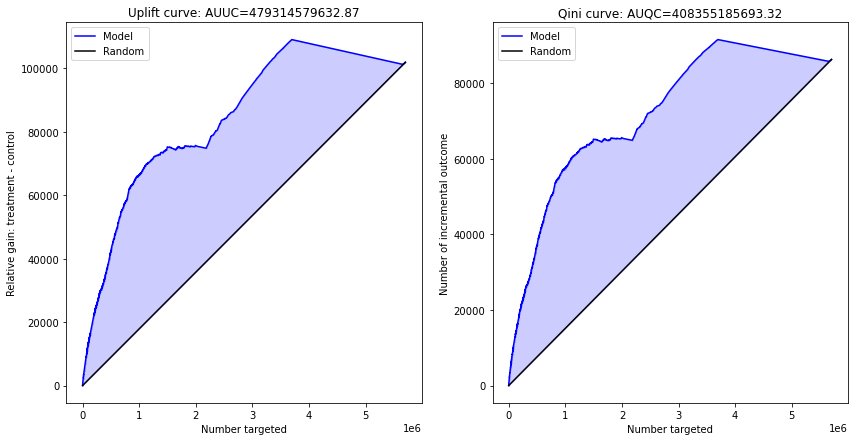

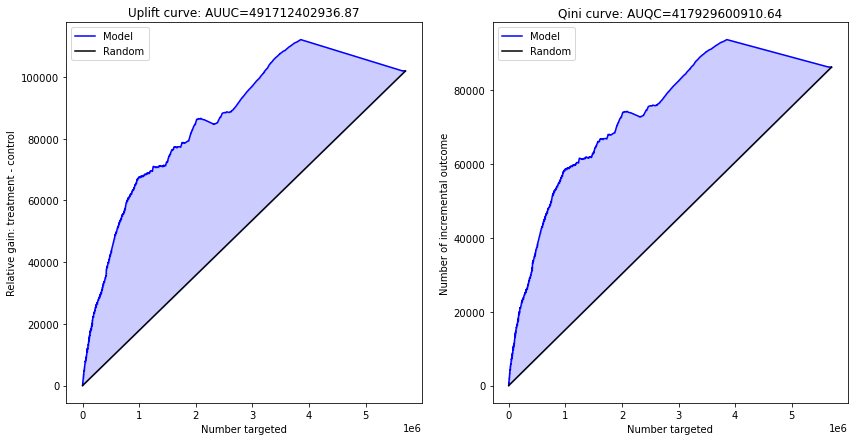

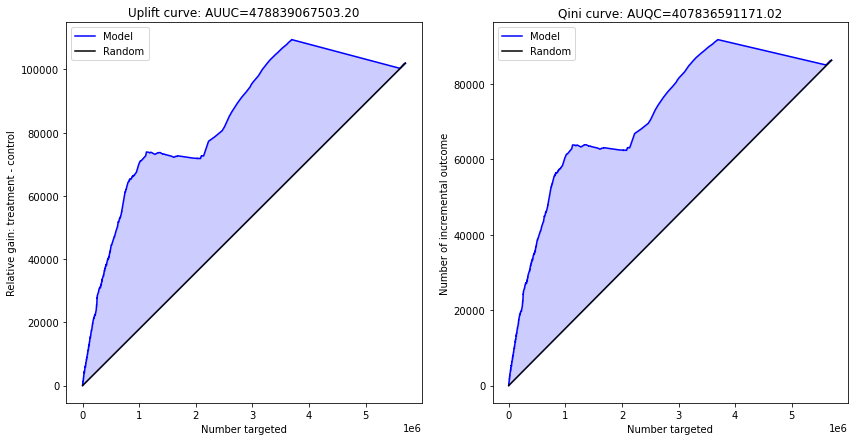

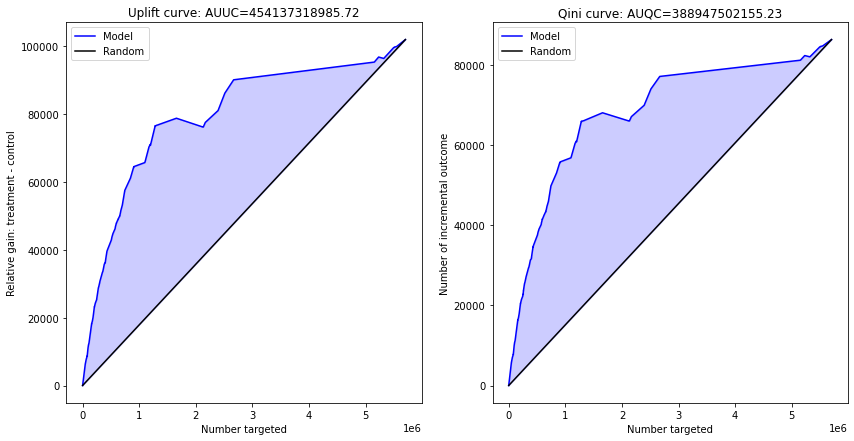

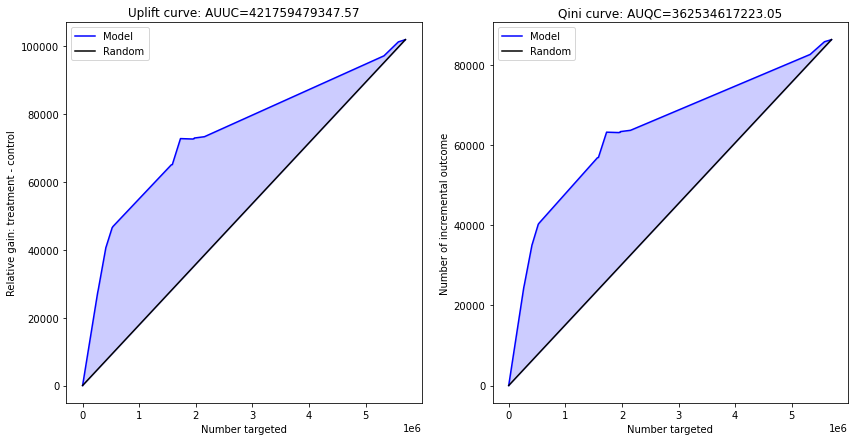

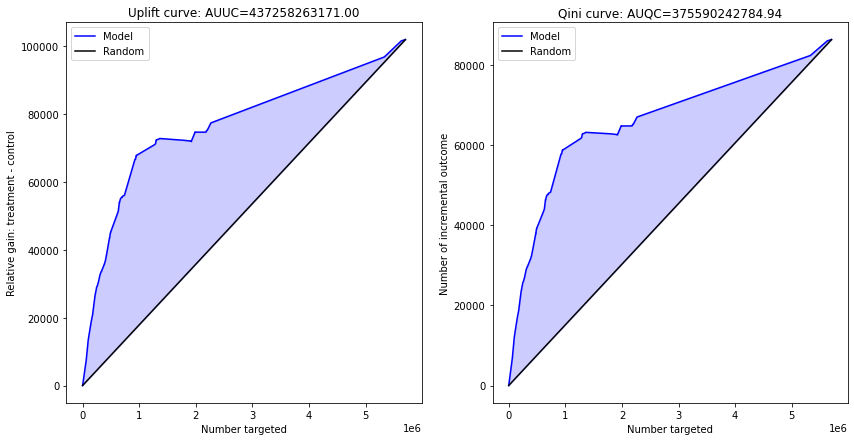

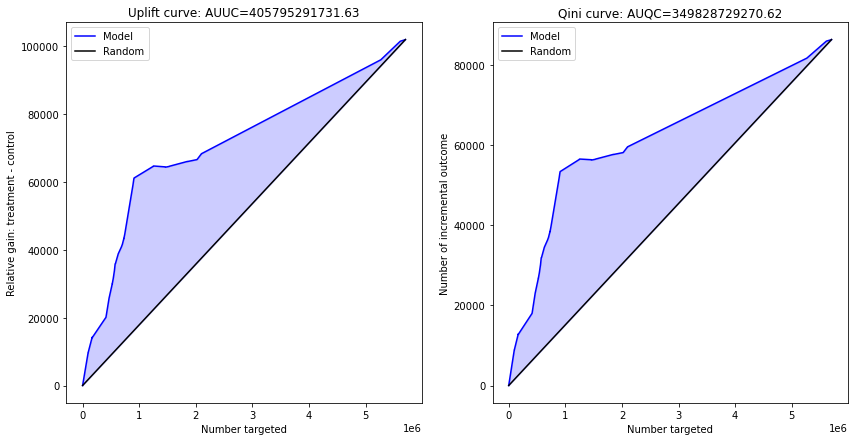

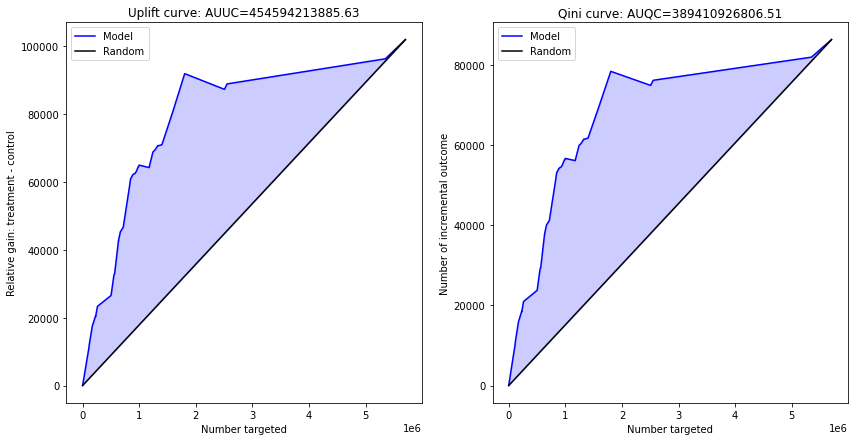

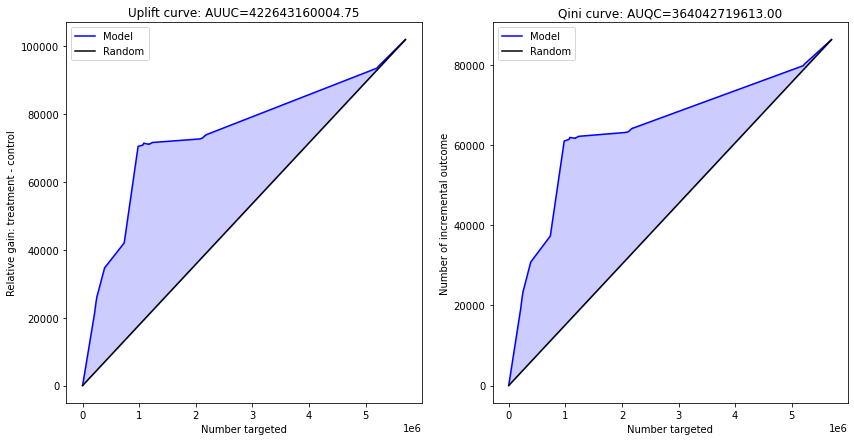

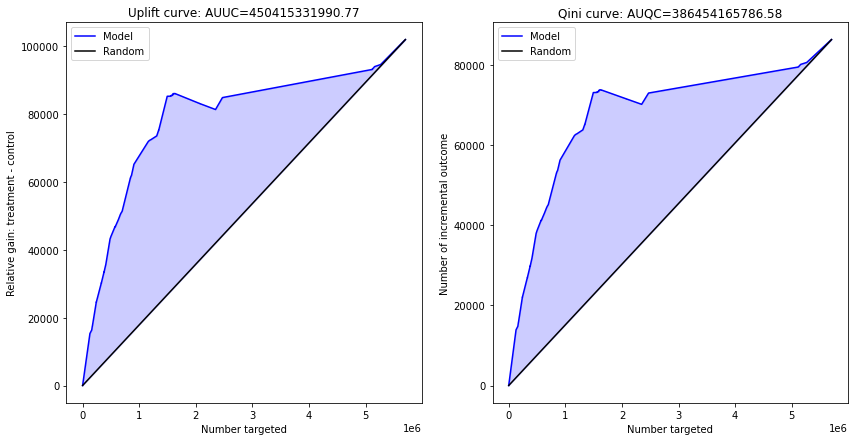

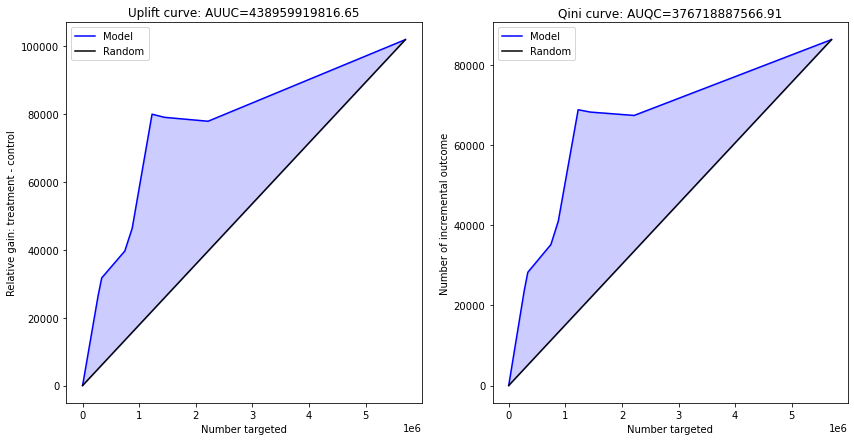

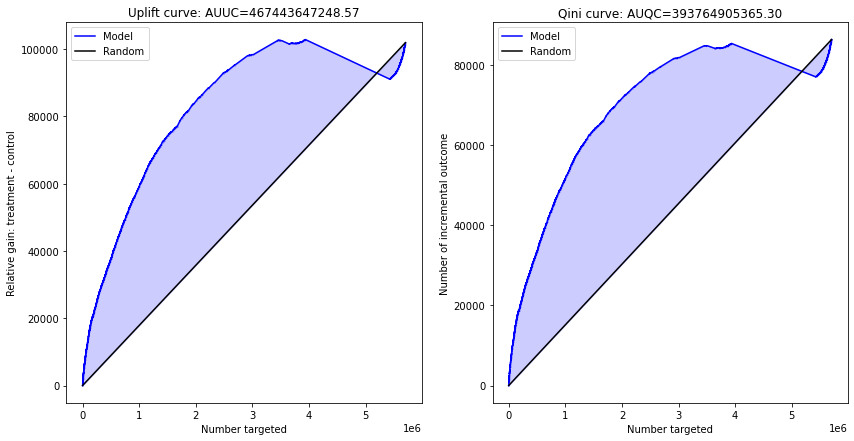

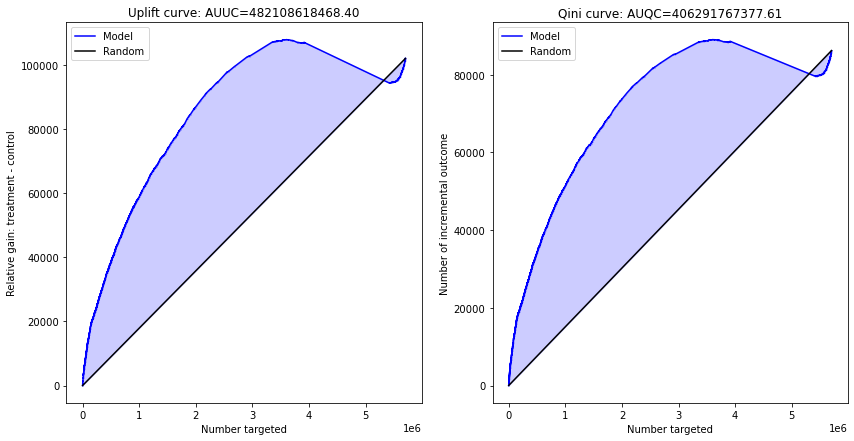

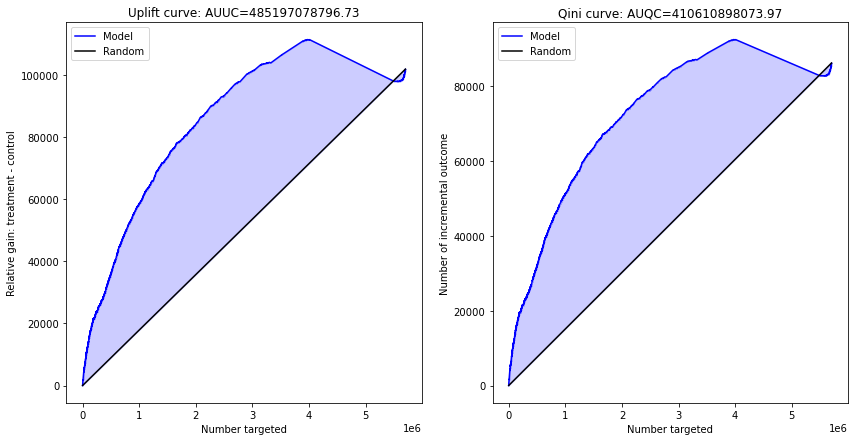

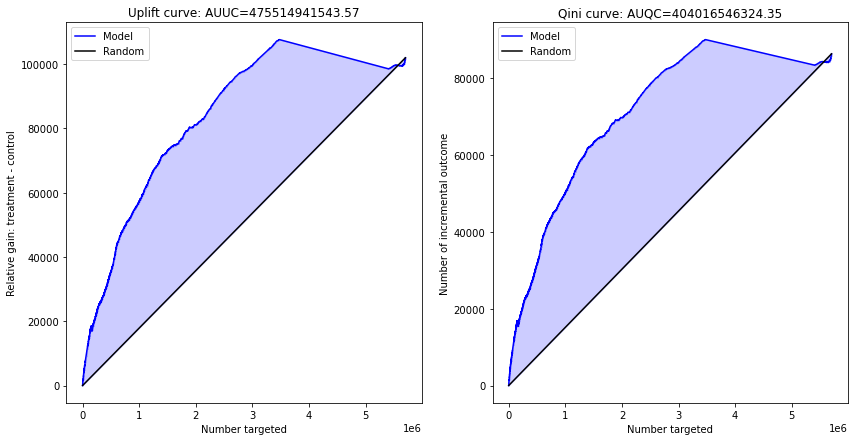

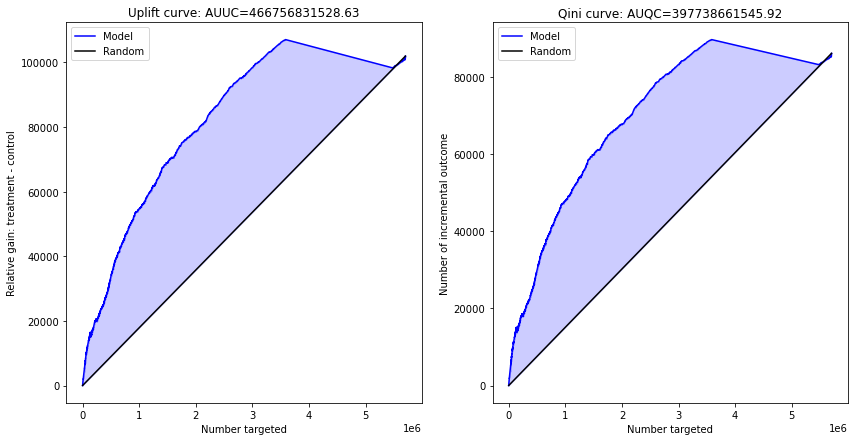

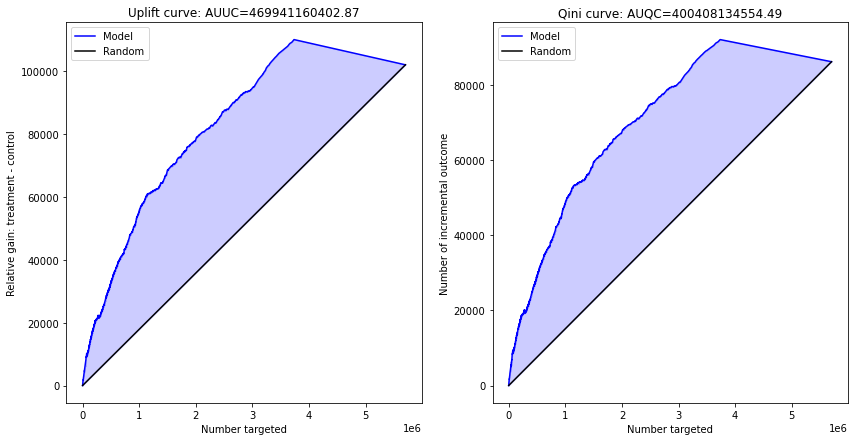

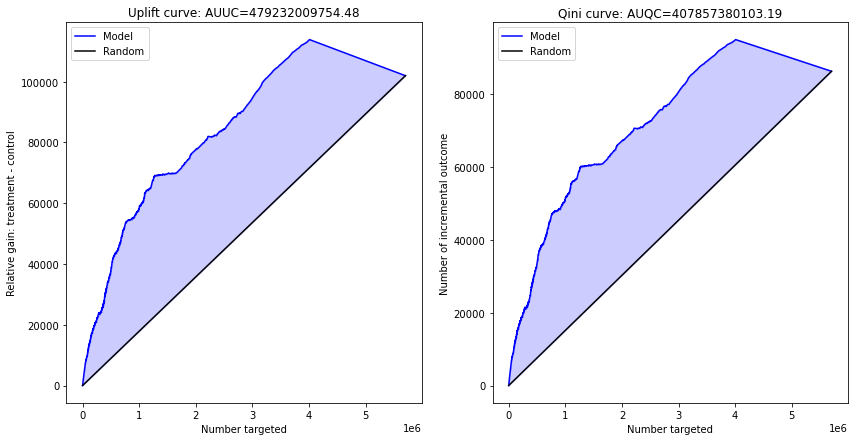

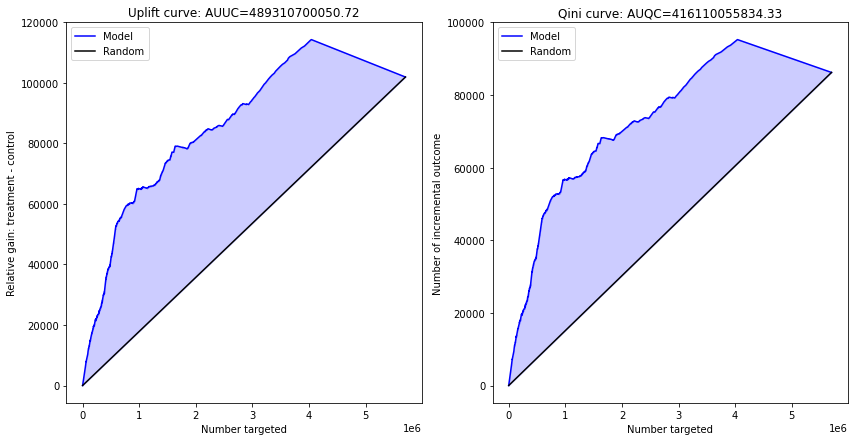

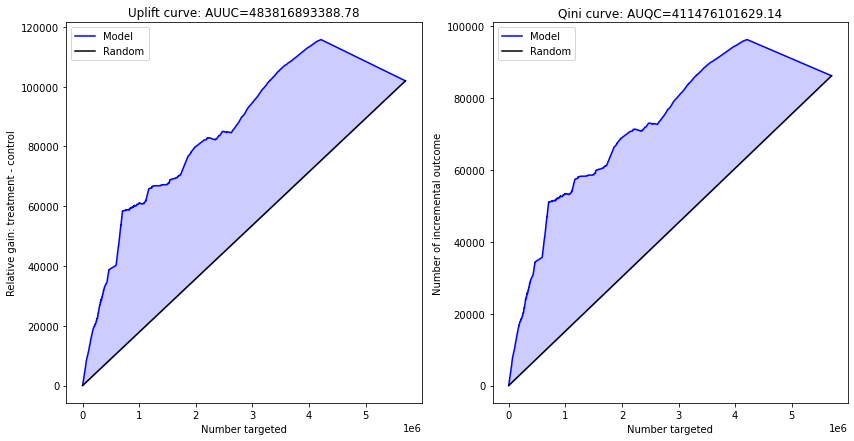

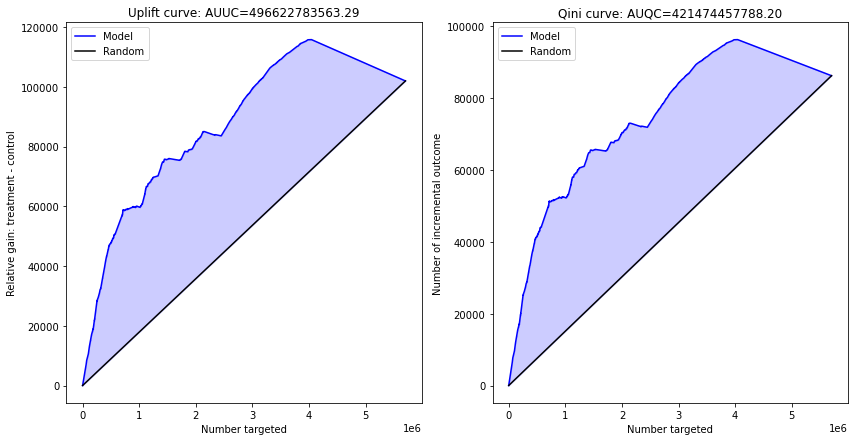

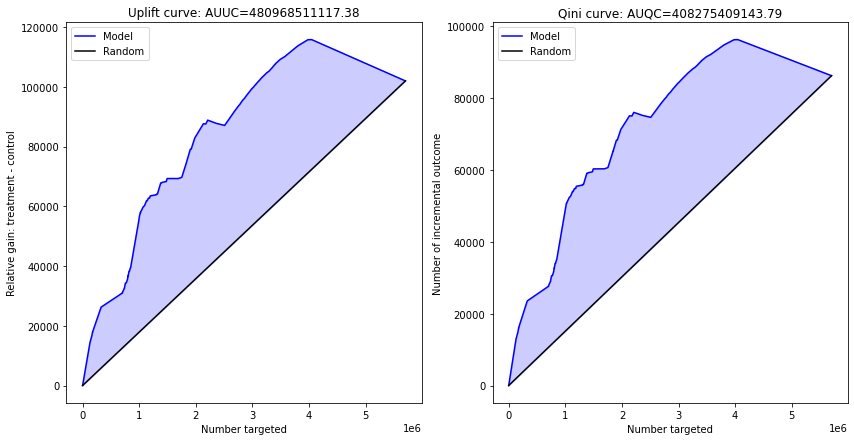

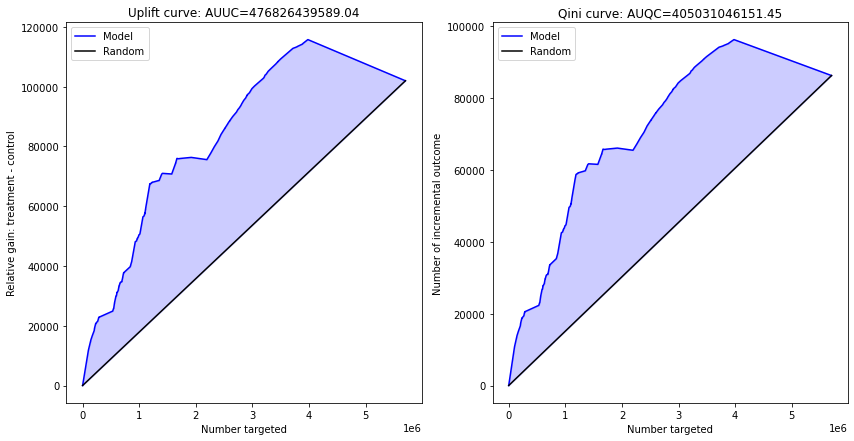

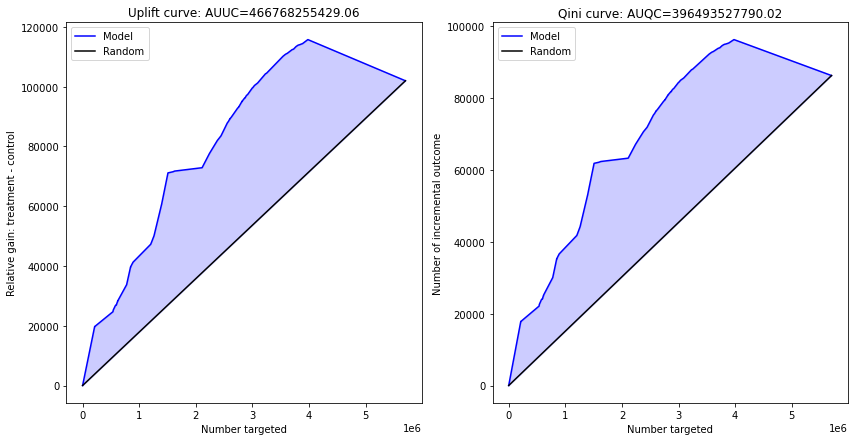

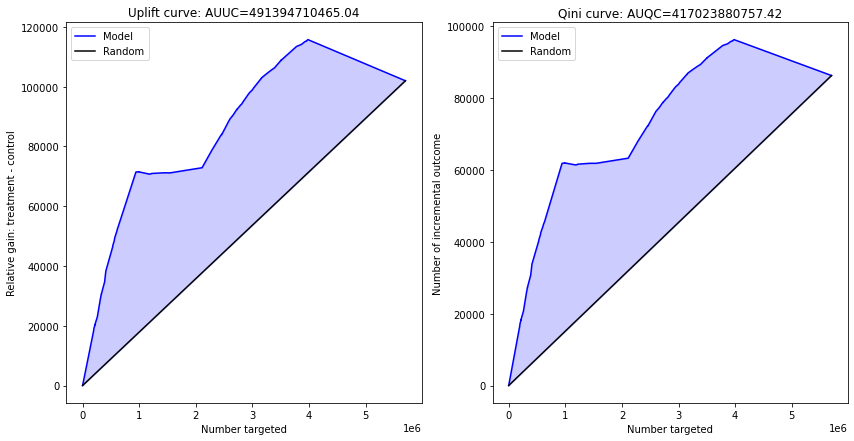

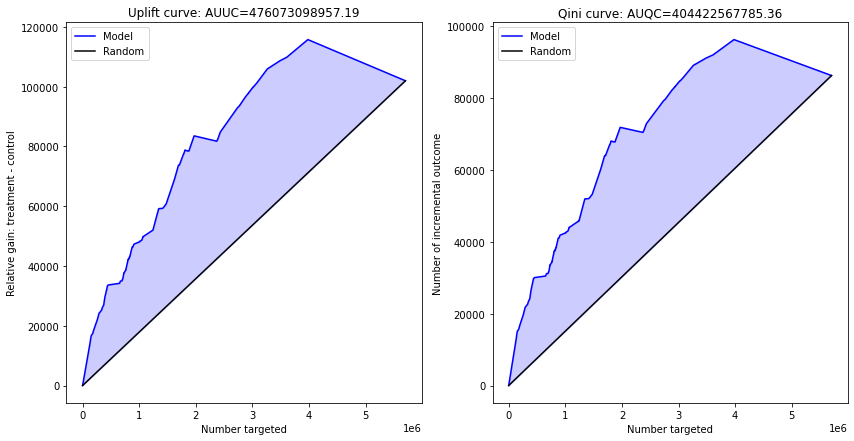

In [40]:
for params in grid_list:
    print(params)
    rfc = RandomForestClassifier(n_estimators = 15, min_samples_leaf= params['min_samples_leaf'], 
    max_features = params['max_features'] , max_depth = None, criterion='uplift_gini')
    start_time = datetime.now()
    rfc.fit(X_train, visit_train, treatment_train)
    time_fit = datetime.now() - start_time
    print("fitting time ", time_fit)
    uplift_pred = rfc.predict_uplift(X_test)

    forest_score = uplift_at_k(y_true=Y_test_visit, uplift=uplift_pred, treatment=treatment_test,strategy= "by_group", k=0.3)
    forest_auqc = qini_auc_score(y_true = Y_test_visit, uplift=uplift_pred, treatment=treatment_test)
    print(uplift_pred)
    print(forest_score)
    print(forest_auqc)
    plot_uplift_qini_curves(y_true=Y_test_visit, uplift=uplift_pred, treatment=treatment_test)


[6.10309538e-05 6.10309538e-05 5.00000000e-01 ... 1.90839695e-03
 7.10592665e-04 6.10309538e-05]
0.04016715542241654
335279998004.94586


d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000280802DADF0>,
      dtype=object)

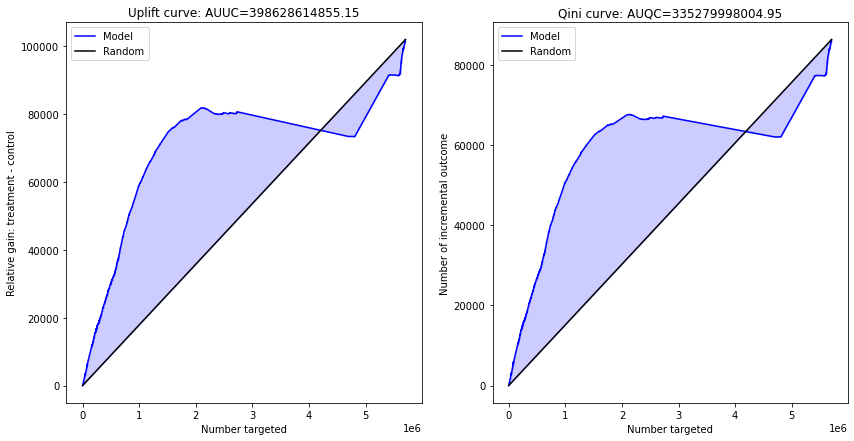

In [36]:
print(uplift_pred)
print(forest_score)
print(forest_auqc)
plot_uplift_qini_curves(y_true=Y_test_visit, uplift=uplift_pred, treatment=treatment_test)